# Cryptocurrency portfolio optimization using Markowitz theory

In [10]:
from binance.client import Client
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [11]:
start,today=dt.datetime(2021,1,1),dt.datetime.today()
start,end= start.strftime("%Y-%m-%d"),today.strftime("%Y-%m-%d")



client = Client(api_key='C3LLv7EZgr2figJFmpDblETNTcseRHyn6uuEuytbynn0o1QT2dH5i7ScgBn3nXuz',
                api_secret='ohlDJqM6l0n3nxdl3RztCbYAQfQMqS6ds6gZi9cokcUjMfiGPpGaAV42wM78sVjV')

In [12]:
def decimal_str(x: float, decimals: int = 10) -> str:         #Scientific notation to decimal format
    return format(x, f".{decimals}f").lstrip().rstrip('0')

In [13]:
info = client.get_account()
zero_list=['0.00000000','0.00','0.0']
balances = info['balances']
assets,values = [],[]
def portfolio(balances):
    for i in range(len(balances)):
        for key in balances[i]:
            if key == 'free':
                if info['balances'][i]['free'] not in zero_list:
                    values.append(balances[i][key])
                    assets.append(balances[i]['asset'])   
    prices=[]
    holding_tickers=[]
    for index, i in enumerate(assets):
            if (i == 'LDUSDT'):
                i = 'BUSD'
                holding_tickers[index] = i
            try:
                X = i + 'USDT'
                prices.append(client.get_ticker(symbol=X))
    
            except Exception:
                X = i + 'BUSD'
                prices.append(client.get_ticker(symbol=X))
    Last_price_of_tickers=[]
    for i in prices :
          Last_price_of_tickers.append(i['lastPrice'])
    estimated_value_in_usdt = []
    for i in range(0, len(Last_price_of_tickers)):
            estimated_value_in_usdt.append(float(Last_price_of_tickers[i]) * float(values[i]))
    suma= sum(estimated_value_in_usdt)
    weights=[]
    for i in estimated_value_in_usdt:
            weights.append(decimal_str((i/suma)*100))
                    
    tickers = {'ammount': values}
    data=pd.DataFrame(tickers,index=assets)
    data.insert(1, "Estimated Value in usdt", estimated_value_in_usdt)
    data.insert(2, "Weights", weights)
    return data,assets,weights

In [14]:
data,holding_tickers,weights=portfolio(balances)
print(data)

            ammount  Estimated Value in usdt        Weights
ETH      0.18426185               562.626975  41.5485244013
BNB      0.00527060                 2.196786   0.1622268822
LINK    22.58829159               318.269029  23.5033318254
VET   3810.94641728               229.800069  16.9701315259
VTHO    33.86078012                 0.142791   0.0105447336
DOT     13.12513072               241.108651  17.8052406316


In [15]:
def get_historical_data(holding_tickers):
    global holding_pairs_with_usdt_or_busd,coins
    series = []
    holding_pairs_with_usdt_or_busd=[]
    for i in holding_tickers:
        X = i + 'USDT'
        try:

            i = client.get_historical_klines(symbol=str(X), interval='1d', start_str=start, end_str=end)
            i_df = pd.DataFrame(i, columns=['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time',
                                            'Quote asset volume', 'Number of trades', 'Taker buy base asset volume',
                                            'Taker buy quote asset volume', 'Ignore'])
            i_df['Open time'] = pd.to_datetime(i_df['Open time'], unit='ms')
            i_df.set_index('Open time', inplace=True)
            i_df['Close'] = i_df['Close'].astype(float)
            series.append(i_df['Close'])
            holding_pairs_with_usdt_or_busd.append(X)
        except:
            X = i + 'BUSD'
            i = client.get_historical_klines(symbol=str(X), interval='1d', start_str=start, end_str=end)
            i_df = pd.DataFrame(i, columns=['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time',
                                           'Quote asset volume', 'Number of trades', 'Taker buy base asset volume',
                                           'Taker buy quote asset volume', 'Ignore'])
            i_df['Open time'] = pd.to_datetime(i_df['Open time'], unit='ms')
            i_df.set_index('Open time', inplace=True)
            i_df['Close'] = i_df['Close'].astype(float)
            series.append(i_df['Close'])
            holding_pairs_with_usdt_or_busd.append(X)

    coins = pd.concat(series, axis=1)
    coins.columns = holding_tickers
    return coins

In [16]:
print(get_historical_data(holding_tickers))

                ETH       BNB     LINK       VET      VTHO      DOT
Open time                                                          
2021-01-01   728.91   37.7762  11.8477  0.019052  0.000695   8.2776
2021-01-02   774.56   38.2331  12.2215  0.019993  0.000704   9.2037
2021-01-03   978.28   41.2575  13.6814  0.026226  0.000796  10.1307
2021-01-04  1041.43   41.1333  13.5935  0.024598  0.000747   9.5126
2021-01-05  1099.56   41.8219  14.5162  0.027964  0.000805   9.7084
...             ...       ...      ...       ...       ...      ...
2022-04-15  3040.56  417.3000  14.1100  0.061600  0.004432  18.3400
2022-04-16  3059.30  417.3000  14.1400  0.061310  0.004255  18.6100
2022-04-17  2988.06  406.6000  13.7300  0.057920  0.004111  17.7400
2022-04-18  3055.56  416.8000  14.0600  0.059600  0.004194  18.1500
2022-04-19  3054.17  416.8000  14.0900  0.060330  0.004217  18.3800

[474 rows x 6 columns]


In [17]:
def correlation_matrix(holding_tickers): #Pearson correlation coefficient
    coins=get_historical_data(holding_tickers)
    sns.heatmap(coins.corr(), annot=True)
    plt.show()


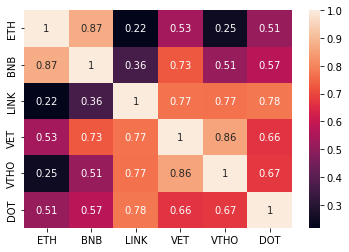

None


In [18]:
print(correlation_matrix(holding_tickers))


In [19]:
def returns(holding_pairs_with_usdt_or_busd):
    Closing_data=pd.DataFrame()
    k=0
    for j in holding_pairs_with_usdt_or_busd:
        i = client.get_historical_klines(symbol=str(j), interval='1d', start_str=start, end_str=end)
        i_df = pd.DataFrame(i, columns=['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time',
                                       'Quote asset volume', 'Number of trades', 'Taker buy base asset volume',
                                       'Taker buy quote asset volume', 'Ignore'])
        i_df['Open time'] = pd.to_datetime(i_df['Open time'], unit='ms')
        i_df.set_index('Open time', inplace=True)
        i_df['Close'] = i_df['Close'].astype(float)
        i_df['Open'] = i_df['Open'].astype(float)
        x=str(j)
        Closing_data.insert(int(k),x,i_df['Close'])
        k+=1
    Closing_data.fillna(0, inplace=True)
    returns=Closing_data.pct_change()
    returns.fillna(0,inplace=True)
    returns = returns.iloc[1: , :]
    return returns
returns(holding_pairs_with_usdt_or_busd)

,ETHUSDT,BNBUSDT,LINKUSDT,VETUSDT,VTHOUSDT,DOTUSDT
Open time,,,,,,
2021-01-02,0.062628,0.012095,0.031550,0.049391,0.012950,0.111880
2021-01-03,0.263014,0.079104,0.119453,0.311759,0.130682,0.100720
2021-01-04,0.064552,-0.003010,-0.006425,-0.062076,-0.061558,-0.061013
2021-01-05,0.055817,0.016741,0.067878,0.136840,0.077644,0.020583
2021-01-06,0.099003,0.010038,0.187101,0.102096,0.014907,0.037030
...,...,...,...,...,...,...
2022-04-15,0.006148,0.006270,0.033700,0.003421,-0.004939,0.024009
2022-04-16,0.006163,0.000000,0.002126,-0.004708,-0.039937,0.014722
2022-04-17,-0.023286,-0.025641,-0.028996,-0.055293,-0.033843,-0.046749


In [20]:
returns=returns(holding_pairs_with_usdt_or_busd)

In [21]:
def std_returns(returns):
    return returns.describe().loc['std']
std_returns(returns)

ETHUSDT     0.053333
BNBUSDT     0.070884
LINKUSDT    0.068741
VETUSDT     0.076931
VTHOUSDT    0.106783
DOTUSDT     0.071379
Name: std, dtype: float64

In [22]:
def mean_returns(returns):
    return returns.mean()
mean_returns(returns)

ETHUSDT     0.004458
BNBUSDT     0.007415
LINKUSDT    0.002757
VETUSDT     0.005369
VTHOUSDT    0.008612
DOTUSDT     0.004205
dtype: float64

In [23]:
def cov_matrix(returns):
    return returns.cov()
cov_matrix(returns)

,ETHUSDT,BNBUSDT,LINKUSDT,VETUSDT,VTHOUSDT,DOTUSDT
ETHUSDT,0.002844,0.002336,0.002871,0.003007,0.002615,0.002812
BNBUSDT,0.002336,0.005025,0.002875,0.003047,0.002935,0.002885
LINKUSDT,0.002871,0.002875,0.004725,0.003954,0.003618,0.003542
VETUSDT,0.003007,0.003047,0.003954,0.005918,0.005735,0.003606
VTHOUSDT,0.002615,0.002935,0.003618,0.005735,0.011403,0.003191
DOTUSDT,0.002812,0.002885,0.003542,0.003606,0.003191,0.005095


In [24]:
weights=[float(i) for i in weights]
weights=np.array(weights)
cov = cov_matrix(returns)

def portfolio_variance(weights,cov):
    return np.dot(weights.T,np.dot(cov,weights))
portfolio_variance(weights,cov)

33.24164416971482

In [25]:
print('Portfolio volatility is:',np.sqrt(portfolio_variance(weights,cov)))

Portfolio volatility is: 5.7655567094353355


In [26]:
mean_returns=mean_returns(returns)
print(mean_returns)

ETHUSDT     0.004458
BNBUSDT     0.007415
LINKUSDT    0.002757
VETUSDT     0.005369
VTHOUSDT    0.008612
DOTUSDT     0.004205
dtype: float64


In [27]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *365
    std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(365)     #365 trading days
    return std, returns
print(portfolio_annualised_performance(weights,mean_returns,cov_matrix))

(110.15080627006733, 152.31070621034817)


# Random Portfolio weights for a Three-Asset Portfolio

### Biased approach

<IPython.core.display.Javascript object>


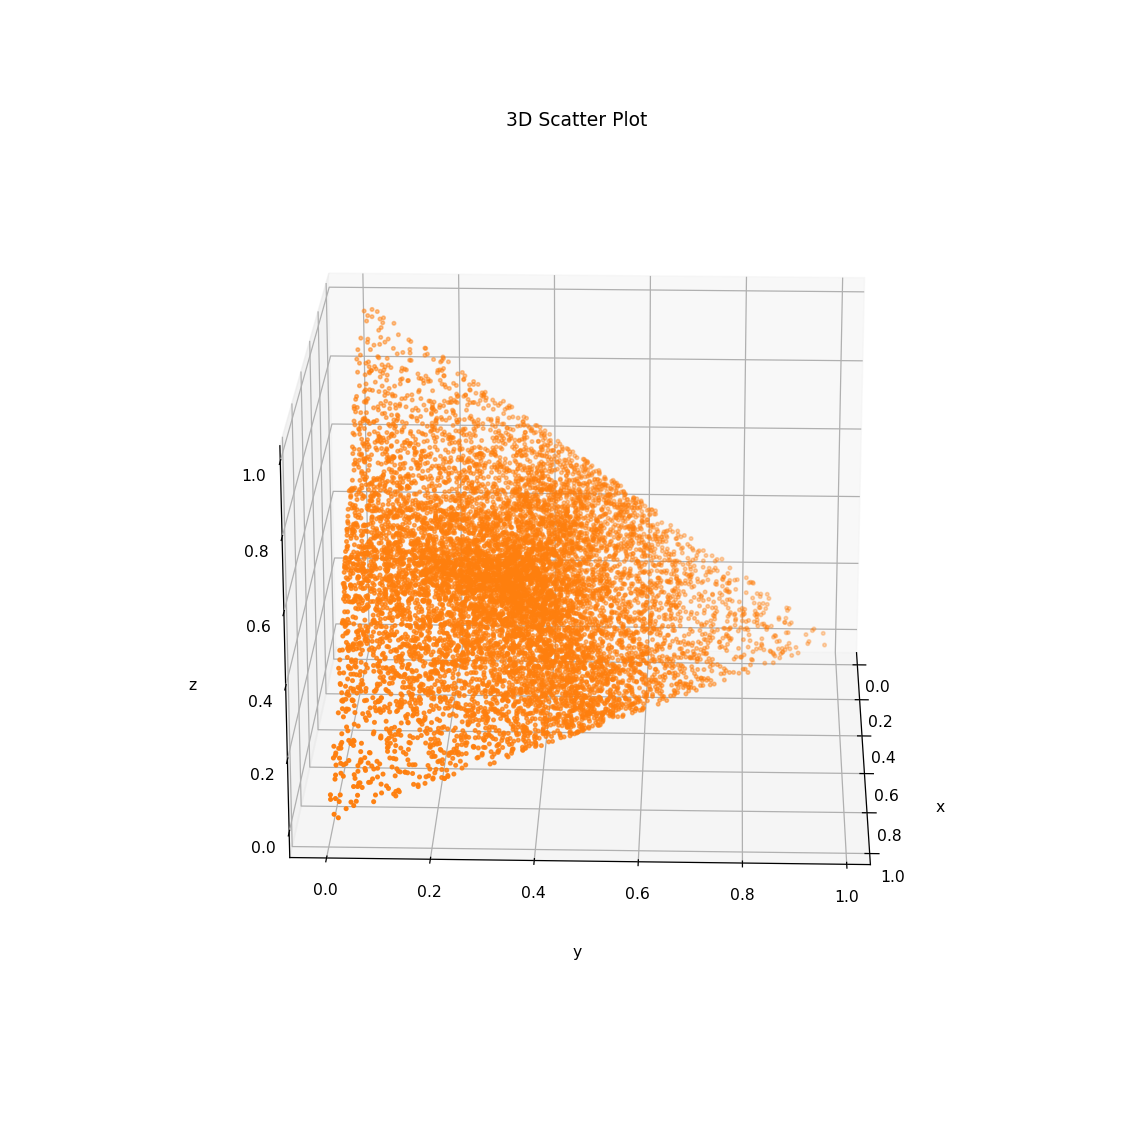

In [28]:
%matplotlib notebook
import matplotlib.pyplot as plt

x=np.zeros((10000,3))
rellocation=[]
for i in range(10000):
    weights = np.random.random(3)
    weights /=np.sum(weights)
    rellocation.append(weights)
norm_w=np.asarray(rellocation)


fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
ax.grid()
ax.scatter(norm_w[:,0],norm_w[:,1],norm_w[:,2], c = '#ff7f0e', s = 5)
ax.set_title('3D Scatter Plot')

# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)
plt.show()




### Unbiased approach

<IPython.core.display.Javascript object>


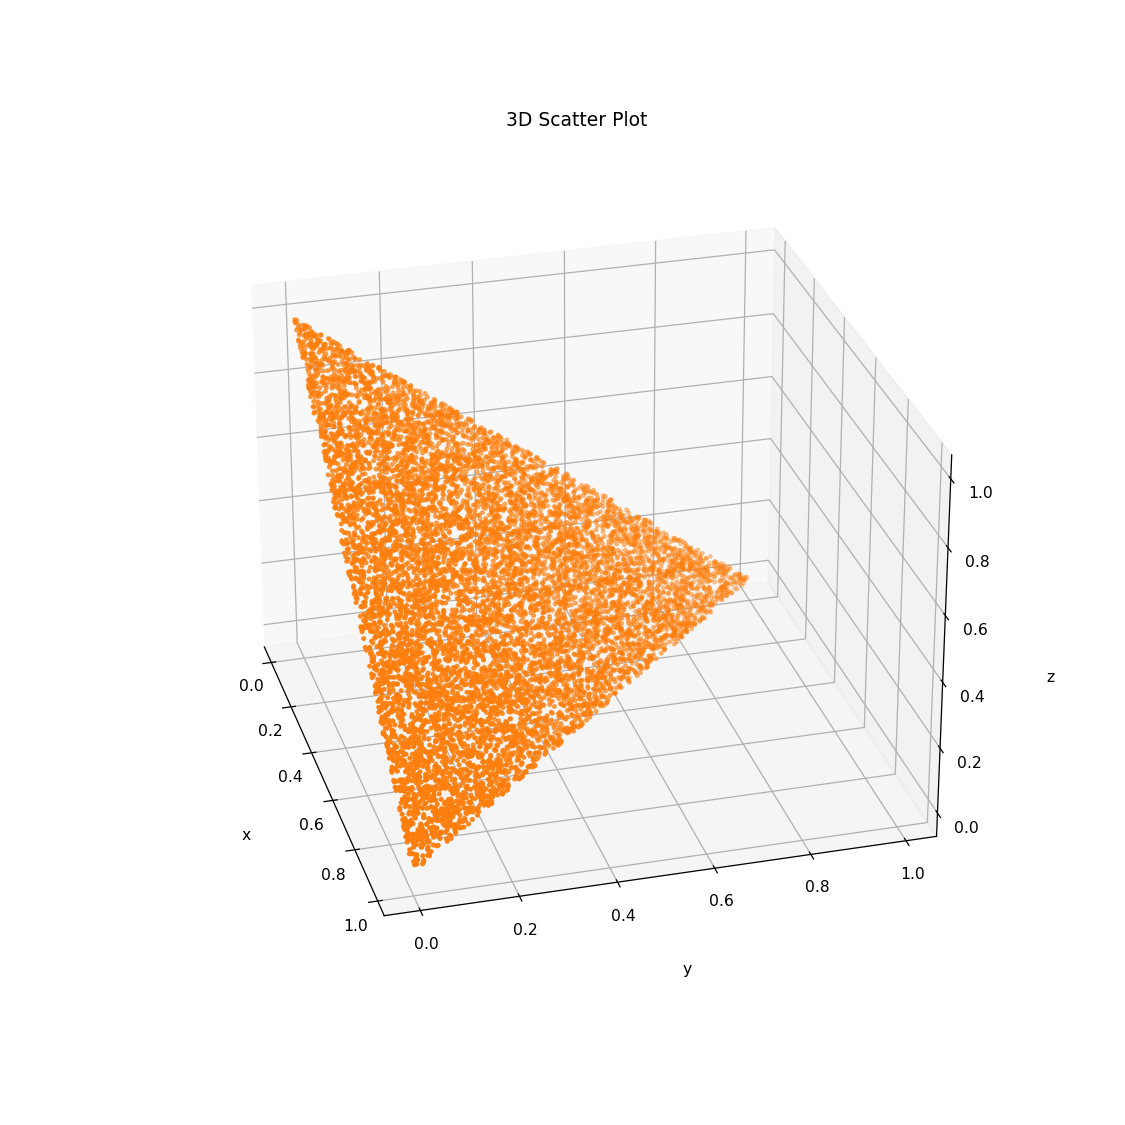

In [47]:

x=np.zeros((10000,3))
rellocation=[]
for i in range(10000):
    weights = np.random.random(2)
    min = np.min(weights)
    max = np.max(weights)
    weights=(min,max-min,1-max)
    rellocation.append(weights)
norm_w=np.asarray(rellocation)


fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
ax.grid()
ax.scatter(norm_w[:,0],norm_w[:,1],norm_w[:,2], c = '#ff7f0e', s = 5)
ax.set_title('3D Scatter Plot')

# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)
plt.show()





### Random Portfolios

In [48]:
risk_free_rate=0.0730
num_of_portfolios=20000

def random_portfolios(num_of_portfolios,mean_returns,cov,risk_free_rate):
    """
    To get n weights satisfying the constrains,generate 
        n-1 points in the unit interval,sort them
        in increasing order and then consider the 
        gaps,including the end points at zero and one.
    """
    
    random_portfolio_data=np.zeros((3,num_of_portfolios))
    random_weights=[]
    for i in range(num_of_portfolios):
        weights = np.random.random(len(holding_tickers)-1)
        a=np.insert(weights,0,[0,1])
        a=np.sort(a)
        b=np.diff(a)
        random_weights.append(b)
        portfolio_std,portfolio_return = portfolio_annualised_performance(b,mean_returns,cov_matrix)
        sharpe_ratio = (portfolio_return-risk_free_rate) /portfolio_std
        random_portfolio_data[0, i] = portfolio_std
        random_portfolio_data[1, i] = portfolio_return
        random_portfolio_data[2, i] = sharpe_ratio
    return random_portfolio_data,random_weights
#print(random_portfolios(num_of_portfolios,mean_returns,cov,risk_free_rate))

Maximum Sharpe Ratio Portfolio 

Annualised Return: 2.616
Annualised Volatility: 1.216


              ETH    BNB  LINK  VET   VTHO   DOT
allocation  10.75  66.03   0.5  0.7  18.49  3.53
_________________________________________________________________
Minimum Volatility Portfolio 

Annualised Return: 1.775
Annualised Volatility: 1.009


              ETH    BNB  LINK   VET  VTHO  DOT
allocation  81.12  13.07  0.67  3.44  0.09  1.6


<IPython.core.display.Javascript object>


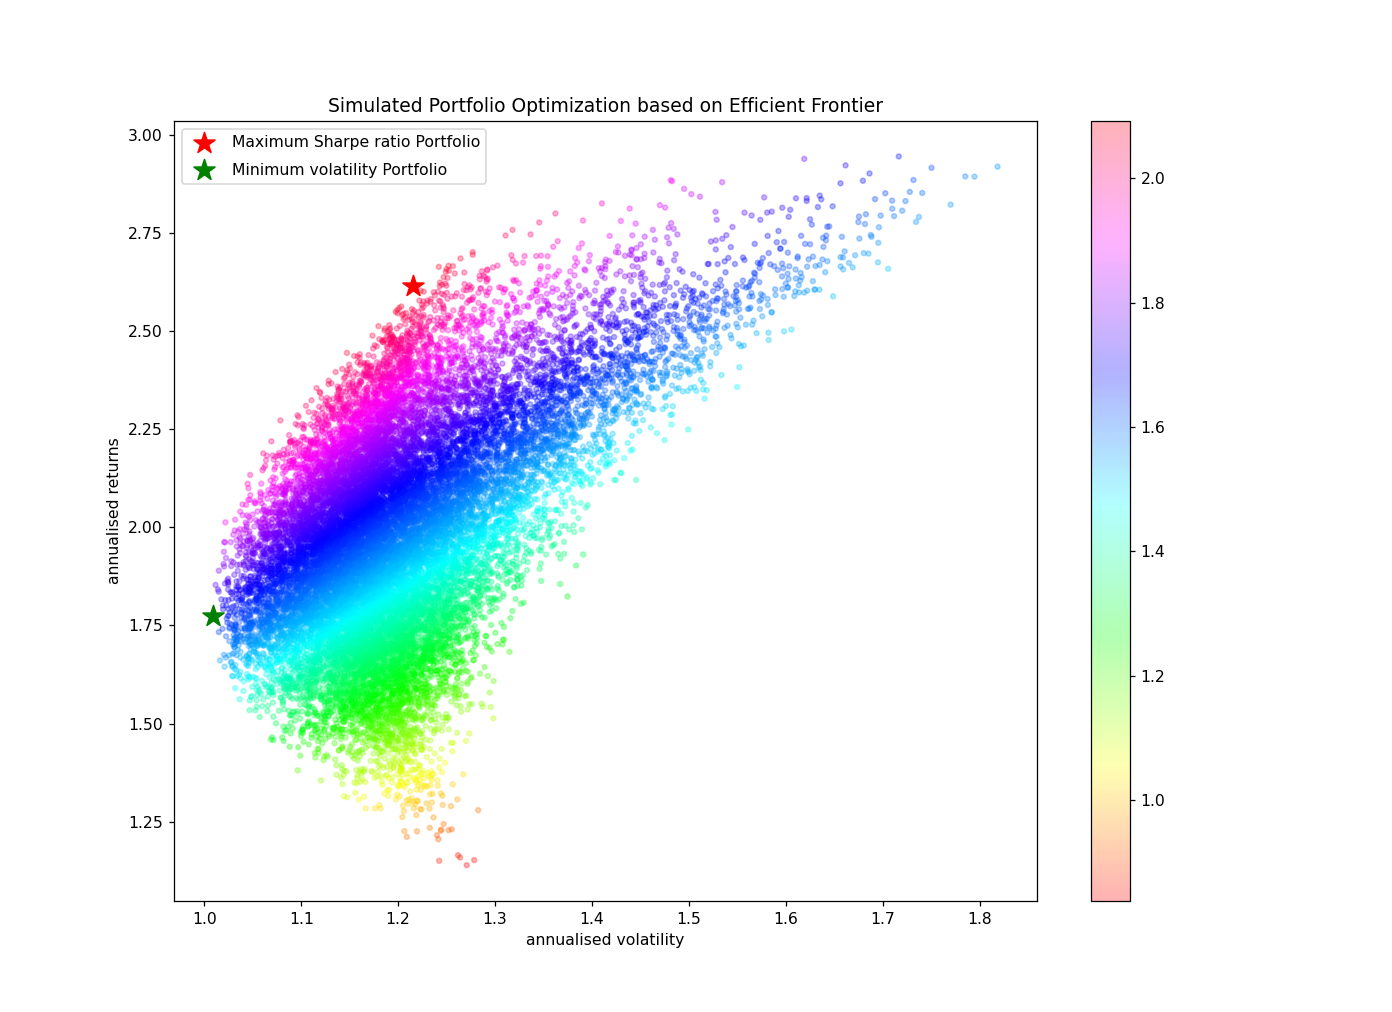

None


In [84]:
def efficient_frontier(mean_returns,cov,num_of_portfolios,risk_free_rate):
    results, weights = random_portfolios(num_of_portfolios, mean_returns, cov, risk_free_rate)
    
    max_sharpe_ratio = np.argmax(results[2]) #position of max_sharpe_ratio in random_potfolio_data[2]
    annualised_return = results[1, max_sharpe_ratio]
    annualised_volatility = results[0, max_sharpe_ratio]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_ratio],index=holding_tickers, columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i * 100, 2) for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = np.argmin(results[0]) #position of min_std in random_portfolio_data[0]
    annualised_volatility_2= results[0, min_vol] 
    annualised_return_2 = results[1, min_vol]
    min_vol_allocation = pd.DataFrame(weights[min_vol],index=holding_tickers, columns=['allocation'])
    min_vol_allocation.allocation = [round(i * 100, 2) for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T


    print('Maximum Sharpe Ratio Portfolio \n')
    print('Annualised Return:', round(annualised_return,3))
    print('Annualised Volatility:', round(annualised_volatility, 3))
    print('\n')
    print(max_sharpe_allocation)
    print('_' * 65)
    print('Minimum Volatility Portfolio \n')
    print('Annualised Return:', round(annualised_return_2, 3))
    print('Annualised Volatility:', round(annualised_volatility_2, 3))
    print('\n')
    print(min_vol_allocation)
    plt.figure(figsize=(11, 8))
    plt.scatter(results[0, :], results[1, :], c=results[2, :], cmap='hsv', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(annualised_volatility, annualised_return, marker='*', color='r', s=200, label='Maximum Sharpe ratio Portfolio')
    plt.scatter(annualised_volatility_2, annualised_return_2, marker='*', color='g', s=200, label='Minimum volatility Portfolio')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)
    plt.show()
print(efficient_frontier(mean_returns,cov_matrix,num_of_portfolios,risk_free_rate))
